<a href="https://colab.research.google.com/github/vikramkrishnan9885/MyColab/blob/master/AdvancedGluonTS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install ujson==1.35
!pip install spacy==2.0.18 folium==0.2.1 imgaug==0.2.7
!pip install --upgrade numpy
!pip install -q mxnet-cu101
!pip install gluonts

!nvcc --version

Requirement already up-to-date: numpy in /usr/local/lib/python3.6/dist-packages (1.19.1)
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2019 NVIDIA Corporation
Built on Sun_Jul_28_19:07:16_PDT_2019
Cuda compilation tools, release 10.1, V10.1.243


In [2]:
%matplotlib inline
import mxnet as mx
from mxnet import gluon
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
import os
from itertools import islice
from pathlib import Path

In [3]:
mx.random.seed(0)
np.random.seed(0)

GluonTS offers three different options to practitioners that want to experiment with the various modules:
* Use an available dataset provided by GluonTS
* Create an artificial dataset using GluonTS
* Convert your dataset to a GluonTS friendly format

In [42]:
!pip freeze | grep ujson

ujson==1.35


In [44]:
import json
from gluonts.dataset.repository.datasets import get_dataset, dataset_recipes
from gluonts.dataset.util import to_pandas

# Create artificial datasets
We can easily create a complex artificial time series dataset using the ComplexSeasonalTimeSeries module.

In [45]:
from gluonts.dataset.artificial import ComplexSeasonalTimeSeries
from gluonts.dataset.common import ListDataset

In [46]:
artificial_dataset = ComplexSeasonalTimeSeries(
    num_series=10,
    prediction_length=21,
    freq_str="H",
    length_low=30,
    length_high=200,
    min_val=-10000,
    max_val=10000,
    is_integer=False,
    proportion_missing_values=0,
    is_noise=True,
    is_scale=True,
    percentage_unique_timestamps=1,
    is_out_of_bounds_date=True,
)

In [47]:
print(f"prediction length: {artificial_dataset.metadata.prediction_length}")
print(f"frequency: {artificial_dataset.metadata.freq}")

prediction length: 21
frequency: H


In [48]:
# The artificial dataset that we created is a list of dictionaries. 
# Each dictionary corresponds to a time series and it should contain the required fields.

print(f"type of train dataset: {type(artificial_dataset.train)}")
print(f"train dataset fields: {artificial_dataset.train[0].keys()}")
print(f"type of test dataset: {type(artificial_dataset.test)}")
print(f"test dataset fields: {artificial_dataset.test[0].keys()}")

type of train dataset: <class 'list'>
train dataset fields: dict_keys(['start', 'target', 'item_id'])
type of test dataset: <class 'list'>
test dataset fields: dict_keys(['start', 'target', 'item_id'])


In [49]:
# In order to use the artificially created datasets (list of dictionaries) 
# we need to convert them to ListDataset objects.
train_ds = ListDataset(
    artificial_dataset.train,
    freq=artificial_dataset.metadata.freq
)

test_ds = ListDataset(
    artificial_dataset.test,
    freq=artificial_dataset.metadata.freq
)

train_entry = next(iter(train_ds))
train_entry.keys()

dict_keys(['start', 'target', 'item_id', 'source'])

In [50]:
test_entry = next(iter(test_ds))
test_entry.keys()

dict_keys(['start', 'target', 'item_id', 'source'])

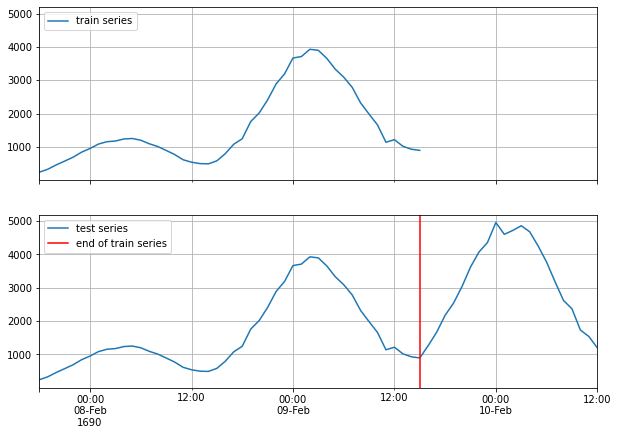

In [51]:
test_series = to_pandas(test_entry)
train_series = to_pandas(train_entry)

fig, ax = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(10, 7))

train_series.plot(ax=ax[0])
ax[0].grid(which="both")
ax[0].legend(["train series"], loc="upper left")

test_series.plot(ax=ax[1])
ax[1].axvline(train_series.index[-1], color='r') # end of train dataset
ax[1].grid(which="both")
ax[1].legend(["test series", "end of train series"], loc="upper left")

plt.show()

In [52]:
from gluonts.dataset.field_names import FieldName

In [53]:
[f"FieldName.{k} = '{v}'" for k, v in FieldName.__dict__.items() if not k.startswith('_')]

["FieldName.ITEM_ID = 'item_id'",
 "FieldName.START = 'start'",
 "FieldName.TARGET = 'target'",
 "FieldName.FEAT_STATIC_CAT = 'feat_static_cat'",
 "FieldName.FEAT_STATIC_REAL = 'feat_static_real'",
 "FieldName.FEAT_DYNAMIC_CAT = 'feat_dynamic_cat'",
 "FieldName.FEAT_DYNAMIC_REAL = 'feat_dynamic_real'",
 "FieldName.FEAT_TIME = 'time_feat'",
 "FieldName.FEAT_CONST = 'feat_dynamic_const'",
 "FieldName.FEAT_AGE = 'feat_dynamic_age'",
 "FieldName.OBSERVED_VALUES = 'observed_values'",
 "FieldName.IS_PAD = 'is_pad'",
 "FieldName.FORECAST_START = 'forecast_start'",
 "FieldName.TARGET_DIM_INDICATOR = 'target_dimension_indicator'"]

The fields are split into three categories (__ROT__): the required ones, the optional ones, and the ones that can be added by the Transformation (explained in a while).

* Required:
  * start: start date of the time series
  * target: values of the time series
* Optional:
  * feat_static_cat: static (over time) categorical features, list with dimension equal to the number of features
  * feat_static_real: static (over time) real features, list with dimension equal to the number of features
  * feat_dynamic_cat: dynamic (over time) categorical features, array with shape equal to (number of features, target length)
  * feat_dynamic_real: dynamic (over time) real features, array with shape equal to (number of features, target length)
* Added by Transformation:
  * time_feat: time related features such as the month or the day
  * feat_dynamic_const: expands a constant value feature along the time axis
  * feat_dynamic_age: age feature, i.e., a feature that its value is small for distant past timestamps and it monotonically increases the more we approach the current timestamp
  * observed_values: indicator for observed values, i.e., a feature that equals to 1 if the value is observed and 0 if the value is missing
  * is_pad: indicator for each time step that shows if it is padded (if the length is not enough)
  * forecast_start: forecast start date

The dataset consists of a target, a real dynamic feature (which in this example we set to be the target value one period earlier), and a static categorical feature that indicates the sinusoid type (different phase) that we used to create the target.

In [54]:
def create_dataset(num_series, num_steps, period=24, mu=1, sigma=0.3):
    # create target: noise + pattern
    # noise
    noise = np.random.normal(mu, sigma, size=(num_series, num_steps))

    # pattern - sinusoid with different phase
    sin_minumPi_Pi = np.sin(np.tile(np.linspace(-np.pi, np.pi, period), int(num_steps / period)))
    sin_Zero_2Pi = np.sin(np.tile(np.linspace(0, 2 * np.pi, 24), int(num_steps / period)))

    pattern = np.concatenate((np.tile(sin_minumPi_Pi.reshape(1, -1),
                                      (int(np.ceil(num_series / 2)),1)),
                              np.tile(sin_Zero_2Pi.reshape(1, -1),
                                      (int(np.floor(num_series / 2)), 1))
                             ),
                             axis=0
                            )

    target = noise + pattern

    # create time features: use target one period earlier, append with zeros
    feat_dynamic_real = np.concatenate((np.zeros((num_series, period)),
                                        target[:, :-period]
                                       ),
                                       axis=1
                                      )

    # create categorical static feats: use the sinusoid type as a categorical feature
    feat_static_cat = np.concatenate((np.zeros(int(np.ceil(num_series / 2))),
                                      np.ones(int(np.floor(num_series / 2)))
                                     ),
                                     axis=0
                                    )

    return target, feat_dynamic_real, feat_static_cat


# define the parameters of the dataset
custom_ds_metadata = {'num_series': 100,
                      'num_steps': 24 * 7,
                      'prediction_length': 24,
                      'freq': '1H',
                      'start': [pd.Timestamp("01-01-2019", freq='1H')
                                for _ in range(100)]
                     }


data_out = create_dataset(custom_ds_metadata['num_series'],
                          custom_ds_metadata['num_steps'],
                          custom_ds_metadata['prediction_length']
                         )

target, feat_dynamic_real, feat_static_cat = data_out

# We can easily create the train and test datasets by simply filling in the correct fields. 
# Remember that for the train dataset we need to cut the last window.

train_ds = ListDataset([{FieldName.TARGET: target,
                         FieldName.START: start,
                         FieldName.FEAT_DYNAMIC_REAL: [fdr],
                         FieldName.FEAT_STATIC_CAT: [fsc]}
                        for (target, start, fdr, fsc) in zip(target[:, :-custom_ds_metadata['prediction_length']],
                                                             custom_ds_metadata['start'],
                                                             feat_dynamic_real[:, :-custom_ds_metadata['prediction_length']],
                                                             feat_static_cat)],
                      freq=custom_ds_metadata['freq'])

test_ds = ListDataset([{FieldName.TARGET: target,
                        FieldName.START: start,
                        FieldName.FEAT_DYNAMIC_REAL: [fdr],
                        FieldName.FEAT_STATIC_CAT: [fsc]}
                       for (target, start, fdr, fsc) in zip(target,
                                                            custom_ds_metadata['start'],
                                                            feat_dynamic_real,
                                                            feat_static_cat)],
                     freq=custom_ds_metadata['freq'])

* Now, we can examine each entry of the train and test datasets. 
* We should expect that they have the following fields: 
  * target, 
  * start, 
  * feat_dynamic_real and 
  * feat_static_cat.

In [55]:
train_entry = next(iter(train_ds))
train_entry.keys()

dict_keys(['target', 'start', 'feat_dynamic_real', 'feat_static_cat', 'source'])

In [56]:
test_entry = next(iter(test_ds))
test_entry.keys()

dict_keys(['target', 'start', 'feat_dynamic_real', 'feat_static_cat', 'source'])

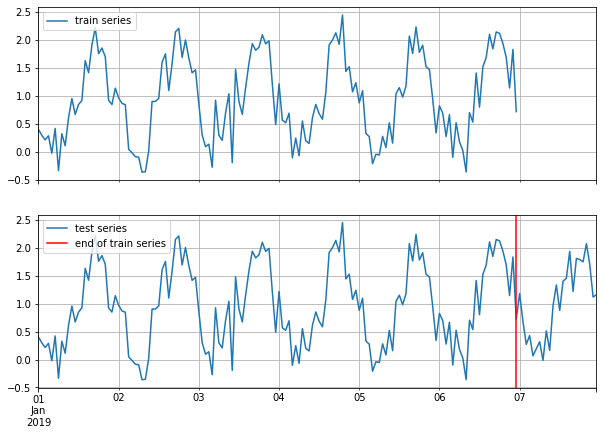

In [57]:
test_series = to_pandas(test_entry)
train_series = to_pandas(train_entry)

fig, ax = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(10, 7))

train_series.plot(ax=ax[0])
ax[0].grid(which="both")
ax[0].legend(["train series"], loc="upper left")

test_series.plot(ax=ax[1])
ax[1].axvline(train_series.index[-1], color='r') # end of train dataset
ax[1].grid(which="both")
ax[1].legend(["test series", "end of train series"], loc="upper left")

plt.show()

# Transformation

The primary use case for a Transformation is for __feature processing__, e.g., adding a holiday feature and for defining the way the dataset will be split into appropriate windows during training and inference.

In general, it __gets an iterable collection of entries of a dataset and transform it to another iterable collection that can possibly contain more fields__. The transformation is done by defining a set of __"actions"__ to the raw dataset depending on what is useful to our model.  As an example, in the following we add the following transformations:
* __AddObservedValuesIndicator__: Creates the observed_values field in the dataset, i.e., adds a feature that equals to 1 if the value is observed and 0 if the value is missing
* __AddAgeFeature__: Creates the feat_dynamic_age field in the dataset, i.e., adds a feature that its value is small for distant past timestamps and it monotonically increases the more we approach the current timestamp

The __Transformation__ may not define an additional field in the dataset. However, it __always__ needs to define how the datasets are going to be split in example windows during training and testing. This is done with the InstanceSplitter that is configured as follows (skipping the obvious fields):
* `is_pad_field`: indicator if the time series is padded (if the length is not enough)
* `train_sampler`: defines how the training windows are cut/sampled
* `time_series_fields`: contains the time dependent features that need to be split in the same manner as the target


In [58]:
from gluonts.transform import (
    AddAgeFeature,
    AddObservedValuesIndicator,
    Chain,
    ExpectedNumInstanceSampler,
    InstanceSplitter,
    SetFieldIfNotPresent,
)

def create_transformation(freq, context_length, prediction_length):
    return Chain(
        [
            AddObservedValuesIndicator(
                target_field=FieldName.TARGET,
                output_field=FieldName.OBSERVED_VALUES,
            ),
            AddAgeFeature(
                target_field=FieldName.TARGET,
                output_field=FieldName.FEAT_AGE,
                pred_length=prediction_length,
                log_scale=True,
            ),
            InstanceSplitter(
                target_field=FieldName.TARGET,
                is_pad_field=FieldName.IS_PAD,
                start_field=FieldName.START,
                forecast_start_field=FieldName.FORECAST_START,
                train_sampler=ExpectedNumInstanceSampler(num_instances=1),
                past_length=context_length,
                future_length=prediction_length,
                time_series_fields=[
                    FieldName.FEAT_AGE,
                    FieldName.FEAT_DYNAMIC_REAL,
                    FieldName.OBSERVED_VALUES,
                ],
            ),
        ]
    )

In [59]:
transformation = create_transformation(custom_ds_metadata['freq'],
                                       2 * custom_ds_metadata['prediction_length'], # can be any appropriate value
                                       custom_ds_metadata['prediction_length'])

When is_train=True in the transformation, the InstanceSplitter iterates over the transformed dataset and cuts windows by selecting randomly a time series and a starting point on that time series (this “randomness” is defined by the train_sampler).

In [60]:
train_tf = transformation(iter(train_ds), is_train=True)
type(train_tf)

generator

In [61]:
train_tf_entry = next(iter(train_tf))
[k for k in train_tf_entry.keys()]

['start',
 'feat_static_cat',
 'source',
 'past_feat_dynamic_age',
 'future_feat_dynamic_age',
 'past_feat_dynamic_real',
 'future_feat_dynamic_real',
 'past_observed_values',
 'future_observed_values',
 'past_target',
 'future_target',
 'past_is_pad',
 'forecast_start']

The transformer has done what we asked. In particular it has added:
* a field for observed values (`observed_values`)
* a field for the age feature (`feat_dynamic_age`)
* some extra useful fields (`past_is_pad`, `forecast_start`)

It has done one more important thing: it has split the window into past and future and has added the corresponding prefixes to all time dependent fields. This way we can easily use e.g., the `past_target` field as input and the `future_target` field to calculate the error of our predictions. Of course, the length of the past is equal to the `context_length` and of the future equal to the `prediction_length`

In [62]:
print(f"past target shape: {train_tf_entry['past_target'].shape}")
print(f"future target shape: {train_tf_entry['future_target'].shape}")
print(f"past observed values shape: {train_tf_entry['past_observed_values'].shape}")
print(f"future observed values shape: {train_tf_entry['future_observed_values'].shape}")
print(f"past age feature shape: {train_tf_entry['past_feat_dynamic_age'].shape}")
print(f"future age feature shape: {train_tf_entry['future_feat_dynamic_age'].shape}")
print(train_tf_entry['feat_static_cat'])

past target shape: (48,)
future target shape: (24,)
past observed values shape: (48,)
future observed values shape: (24,)
past age feature shape: (48, 1)
future age feature shape: (24, 1)
[0]


In [63]:
[k for k in next(iter(train_ds)).keys()]

['target', 'start', 'feat_dynamic_real', 'feat_static_cat', 'source']

In [64]:
test_tf = transformation(iter(test_ds), is_train=False)
test_tf_entry = next(iter(test_tf))
[k for k in test_tf_entry.keys()]

['start',
 'feat_static_cat',
 'source',
 'past_feat_dynamic_age',
 'future_feat_dynamic_age',
 'past_feat_dynamic_real',
 'future_feat_dynamic_real',
 'past_observed_values',
 'future_observed_values',
 'past_target',
 'future_target',
 'past_is_pad',
 'forecast_start']

In [65]:
print(f"past target shape: {test_tf_entry['past_target'].shape}")
print(f"future target shape: {test_tf_entry['future_target'].shape}")
print(f"past observed values shape: {test_tf_entry['past_observed_values'].shape}")
print(f"future observed values shape: {test_tf_entry['future_observed_values'].shape}")
print(f"past age feature shape: {test_tf_entry['past_feat_dynamic_age'].shape}")
print(f"future age feature shape: {test_tf_entry['future_feat_dynamic_age'].shape}")
print(test_tf_entry['feat_static_cat'])

past target shape: (48,)
future target shape: (0,)
past observed values shape: (48,)
future observed values shape: (0,)
past age feature shape: (48, 1)
future age feature shape: (24, 1)
[0]


In [66]:
from gluonts.model.simple_feedforward import SimpleFeedForwardEstimator
from gluonts.trainer import Trainer

estimator = SimpleFeedForwardEstimator(
    num_hidden_dimensions=[10],
    prediction_length=custom_ds_metadata['prediction_length'],
    context_length=2*custom_ds_metadata['prediction_length'],
    freq=custom_ds_metadata['freq'],
    trainer=Trainer(ctx="cpu",
                    epochs=5,
                    learning_rate=1e-3,
                    hybridize=False,
                    num_batches_per_epoch=100
                   )
)

predictor = estimator.train(train_ds)

  0%|          | 0/100 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


100%|██████████| 100/100 [00:00<00:00, 111.75it/s, epoch=5/5, avg_epoch_loss=0.614]


GluonTS comes with the make_evaluation_predictions function that automates the process of prediction and model evaluation. Roughly, this function performs the following steps:
* Removes the final window of length `prediction_length` of the dataset.test that we want to predict
* The estimator uses the __remaining data to predict (in the form of sample paths) the "future" window that was just removed__
* The module outputs the __forecast sample paths__ and the __dataset.test__ (as python generator objects)

# Predictions

In [83]:
from gluonts.evaluation.backtest import make_evaluation_predictions

In [68]:
forecast_it, ts_it = make_evaluation_predictions(
    dataset=test_ds,  # test dataset
    predictor=predictor,  # predictor
    num_samples=100,  # number of sample paths we want for evaluation
)

First, we can convert these generators to lists to ease the subsequent computations.

In [82]:
forecasts = list(forecast_it)
tss = list(ts_it)
#tss

In [70]:
# first entry of the time series list
# We expect the first entry of tss to contain the (target of the) first time series of test_ds.
ts_entry = tss[0]

# first 5 values of the time series (convert from pandas to numpy)
np.array(ts_entry[:5]).reshape(-1,)

array([ 0.40194348,  0.29920882,  0.21578501,  0.28834894, -0.02217778],
      dtype=float32)

In [71]:
# first entry of test_ds
test_ds_entry = next(iter(test_ds))

# first 5 values
test_ds_entry['target'][:5]

array([ 0.40194348,  0.29920882,  0.21578501,  0.28834894, -0.02217778],
      dtype=float32)

In [72]:
# first entry of the forecast list
forecast_entry = forecasts[0]

print(f"Number of sample paths: {forecast_entry.num_samples}")
print(f"Dimension of samples: {forecast_entry.samples.shape}")
print(f"Start date of the forecast window: {forecast_entry.start_date}")
print(f"Frequency of the time series: {forecast_entry.freq}")

Number of sample paths: 100
Dimension of samples: (100, 24)
Start date of the forecast window: 2019-01-07 00:00:00
Frequency of the time series: 1H


In [73]:
print(f"Mean of the future window:\n {forecast_entry.mean}")
print(f"0.5-quantile (median) of the future window:\n {forecast_entry.quantile(0.5)}")

Mean of the future window:
 [ 0.7687885   0.57479066  0.42558858  0.35770085 -0.03998543  0.01786965
  0.04216652  0.16436006  0.3055727   0.57480365  0.68381876  0.92868805
  1.1378901   1.4839767   1.6699803   1.8055857   2.1092532   1.9813521
  1.8803532   1.9119743   1.8196814   1.4288113   1.315247    1.168612  ]
0.5-quantile (median) of the future window:
 [ 0.7709384   0.5722398   0.37283054  0.41722664 -0.04640997  0.07672715
  0.02357208  0.17925902  0.32135636  0.5326626   0.72498083  1.0249072
  1.1320527   1.4835811   1.6571349   1.754259    2.0429163   1.9488655
  1.8956212   1.9338121   1.8165689   1.5020033   1.3492587   1.1550597 ]


In [74]:
def plot_prob_forecasts(ts_entry, forecast_entry):
    plot_length = 150
    prediction_intervals = (50.0, 90.0)
    legend = ["observations", "median prediction"] + [f"{k}% prediction interval" for k in prediction_intervals][::-1]

    fig, ax = plt.subplots(1, 1, figsize=(10, 7))
    ts_entry[-plot_length:].plot(ax=ax)  # plot the time series
    forecast_entry.plot(prediction_intervals=prediction_intervals, color='g')
    plt.grid(which="both")
    plt.legend(legend, loc="upper left")
    plt.show()

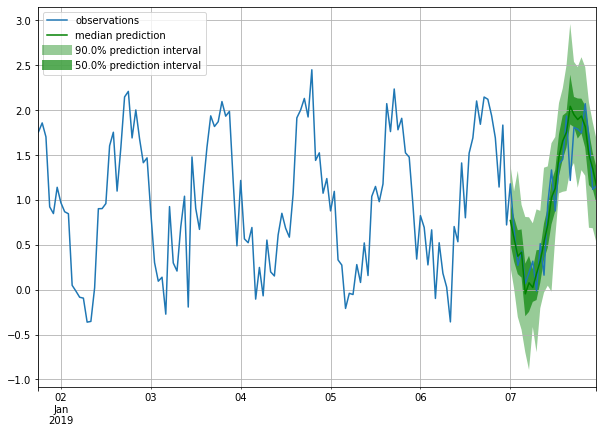

In [75]:
plot_prob_forecasts(ts_entry, forecast_entry)

## Metrics for evaluation

In [76]:
from gluonts.evaluation import Evaluator

In [77]:
evaluator = Evaluator(quantiles=[0.1, 0.5, 0.9])
agg_metrics, item_metrics = evaluator(iter(tss), iter(forecasts), num_series=len(test_ds))

Running evaluation: 100%|██████████| 100/100 [00:00<00:00, 4204.44it/s]


In [78]:
print(json.dumps(agg_metrics, indent=4))

{
    "MSE": 0.12162884215513863,
    "abs_error": 665.8266272544861,
    "abs_target_sum": 2509.9790267944336,
    "abs_target_mean": 1.0458245944976805,
    "seasonal_error": 0.3390809672673543,
    "MASE": 0.8222465866000758,
    "MAPE": 1.775539882557497,
    "sMAPE": 0.5514238612174842,
    "OWA": NaN,
    "MSIS": 7.320265780281107,
    "QuantileLoss[0.1]": 297.9266677971929,
    "Coverage[0.1]": 0.11375000000000002,
    "QuantileLoss[0.5]": 665.8266295599751,
    "Coverage[0.5]": 0.5091666666666665,
    "QuantileLoss[0.9]": 307.3730945164337,
    "Coverage[0.9]": 0.8795833333333336,
    "RMSE": 0.34875326830746495,
    "NRMSE": 0.3334720469783697,
    "ND": 0.2652717891849608,
    "wQuantileLoss[0.1]": 0.11869687539886882,
    "wQuantileLoss[0.5]": 0.26527179010349,
    "wQuantileLoss[0.9]": 0.12246042346775651,
    "mean_wQuantileLoss": 0.16880969632337176,
    "MAE_Coverage": 0.014444444444444324
}


In [79]:
item_metrics.head()

,item_id,MSE,abs_error,abs_target_sum,abs_target_mean,seasonal_error,MASE,MAPE,sMAPE,OWA,MSIS,QuantileLoss[0.1],Coverage[0.1],QuantileLoss[0.5],Coverage[0.5],QuantileLoss[0.9],Coverage[0.9]
0,NaN,0.082750,5.121516,24.381290,1.015887,0.372056,0.573561,0.920208,0.471269,NaN,4.194084,2.953334,0.083333,5.121517,0.458333,2.380882,1.000000
1,NaN,0.080070,5.765226,24.990339,1.041264,0.305420,0.786516,0.511279,0.394038,NaN,3.713232,2.194221,0.125000,5.765227,0.458333,2.297045,0.916667
2,NaN,0.090272,5.375115,26.256813,1.094034,0.325431,0.688205,0.630792,0.558952,NaN,7.593437,2.223640,0.041667,5.375115,0.541667,3.765395,0.833333
3,NaN,0.132005,7.045155,26.670816,1.111284,0.336027,0.873586,0.604077,0.482731,NaN,8.799925,3.113174,0.208333,7.045155,0.375000,3.305107,0.791667
4,NaN,0.149351,7.953507,24.797359,1.033223,0.342568,0.967386,0.928238,0.534840,NaN,10.160505,3.785291,0.208333,7.953507,0.583333,3.099930,0.916667


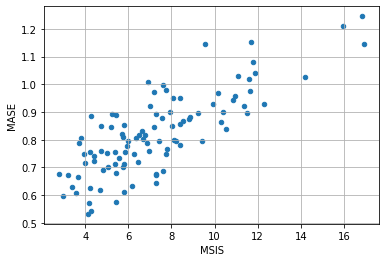

In [80]:
item_metrics.plot(x='MSIS', y='MASE', kind='scatter')
plt.grid(which="both")
plt.show()

# Probabilistic forecasting

* Probabilistic forecasting requires that __we learn the distribution of the future values of the time series__ and not the values themselves as in point forecasting. 
* To achieve this, we need to __specify the type of distribution__ that the future values follow. 
  * GluonTS comes with a number of different distributions that cover many use cases, such as __Gaussian, Student-t and Uniform__ just to name a few.
* In order to learn a distribution __we need to learn its parameters__. 
  * For example, in the simple case where we assume a __Gaussian__ distribution, we need to learn the __mean and the variance__ that fully specify the distribution.
* Each distribution that is available in GluonTS is defined by the corresponding __Distribution__ class (e.g., Gaussian). 
  * This class defines -among others- the parameters of the distribution, __its (log-)likelihood and a sampling method__ (given the parameters).
* Each distribution comes with a `DistributionOutput` class (e.g., GaussianOutput). The role of this class is to connect a model with a distribution. Its main usage is to take the output of the model and map it to the parameters of the distribution. 

## Changes to the point estimate models

First, we need to change the output of the network. In the point forecast network the output was a vector of length prediction_length that gave directly the point estimates. Now, we need to output a set of features that the DistributionOutput will use to project to the distribution parameters. These features should be different for each time step at the prediction horizon. Therefore we need an overall output of prediction_length * num_features values.

The DistributionOutput takes as input a tensor and uses the last dimension as features to be projected to the distribution parameters. Here, we need a distribution object for each time step, i.e., prediction_length distribution objects. Given that the output of the network has prediction_length * num_features values, we can reshape it to (prediction_length, num_features) and get the required distributions, while the last axis of length num_features will be projected to the distribution parameters.

We want the prediction network to output many sample paths for each time series. To achieve this we can repeat each time series as many times as the number of sample paths and do a standard forecast for each of them.

In [89]:
from gluonts.distribution.distribution_output import DistributionOutput
from gluonts.distribution.gaussian import GaussianOutput
from gluonts.model.estimator import GluonEstimator
from gluonts.model.predictor import Predictor, RepresentableBlockPredictor
from gluonts.core.component import validated
from gluonts.trainer import Trainer
from gluonts.support.util import copy_parameters
from gluonts.transform import ExpectedNumInstanceSampler, Transformation, InstanceSplitter
from mxnet.gluon import HybridBlock

In [85]:
class MyProbNetwork(gluon.HybridBlock):
    def __init__(self,
                 prediction_length,
                 distr_output,
                 num_cells,
                 num_sample_paths=100,
                 **kwargs
    ) -> None:
        super().__init__(**kwargs)
        self.prediction_length = prediction_length
        self.distr_output = distr_output
        self.num_cells = num_cells
        self.num_sample_paths = num_sample_paths
        self.proj_distr_args = distr_output.get_args_proj()

        with self.name_scope():
            # Set up a 2 layer neural network that its ouput will be projected to the distribution parameters
            self.nn = mx.gluon.nn.HybridSequential()
            self.nn.add(mx.gluon.nn.Dense(units=self.num_cells, activation='relu'))
            self.nn.add(mx.gluon.nn.Dense(units=self.prediction_length * self.num_cells, activation='relu'))

In [86]:
class MyProbTrainNetwork(MyProbNetwork):
    def hybrid_forward(self, F, past_target, future_target):
        # compute network output
        net_output = self.nn(past_target)

        # (batch, prediction_length * nn_features)  ->  (batch, prediction_length, nn_features)
        net_output = net_output.reshape(0, self.prediction_length, -1)

        # project network output to distribution parameters domain
        distr_args = self.proj_distr_args(net_output)

        # compute distribution
        distr = self.distr_output.distribution(distr_args)

        # negative log-likelihood
        loss = distr.loss(future_target)
        return loss

In [87]:
class MyProbPredNetwork(MyProbTrainNetwork):
    # The prediction network only receives past_target and returns predictions
    def hybrid_forward(self, F, past_target):
        # repeat past target: from (batch_size, past_target_length) to
        # (batch_size * num_sample_paths, past_target_length)
        repeated_past_target = past_target.repeat(
            repeats=self.num_sample_paths, axis=0
        )

        # compute network output
        net_output = self.nn(repeated_past_target)

        # (batch * num_sample_paths, prediction_length * nn_features)  ->  (batch * num_sample_paths, prediction_length, nn_features)
        net_output = net_output.reshape(0, self.prediction_length, -1)

        # project network output to distribution parameters domain
        distr_args = self.proj_distr_args(net_output)

        # compute distribution
        distr = self.distr_output.distribution(distr_args)

        # get (batch_size * num_sample_paths, prediction_length) samples
        samples = distr.sample()

        # reshape from (batch_size * num_sample_paths, prediction_length) to
        # (batch_size, num_sample_paths, prediction_length)
        return samples.reshape(shape=(-1, self.num_sample_paths, self.prediction_length))

In [90]:
class MyProbEstimator(GluonEstimator):
    @validated()
    def __init__(
            self,
            prediction_length: int,
            context_length: int,
            freq: str,
            distr_output: DistributionOutput,
            num_cells: int,
            num_sample_paths: int = 100,
            trainer: Trainer = Trainer()
    ) -> None:
        super().__init__(trainer=trainer)
        self.prediction_length = prediction_length
        self.context_length = context_length
        self.freq = freq
        self.distr_output = distr_output
        self.num_cells = num_cells
        self.num_sample_paths = num_sample_paths

    def create_transformation(self):
        return InstanceSplitter(
            target_field=FieldName.TARGET,
            is_pad_field=FieldName.IS_PAD,
            start_field=FieldName.START,
            forecast_start_field=FieldName.FORECAST_START,
            train_sampler=ExpectedNumInstanceSampler(num_instances=1),
            past_length=self.context_length,
            future_length=self.prediction_length,
        )

    def create_training_network(self) -> MyProbTrainNetwork:
        return MyProbTrainNetwork(
            prediction_length=self.prediction_length,
            distr_output=self.distr_output,
            num_cells=self.num_cells,
            num_sample_paths=self.num_sample_paths
        )

    def create_predictor(
            self, transformation: Transformation, trained_network: HybridBlock
    ) -> Predictor:
        prediction_network = MyProbPredNetwork(
            prediction_length=self.prediction_length,
            distr_output=self.distr_output,
            num_cells=self.num_cells,
            num_sample_paths=self.num_sample_paths
        )

        copy_parameters(trained_network, prediction_network)

        return RepresentableBlockPredictor(
            input_transform=transformation,
            prediction_net=prediction_network,
            batch_size=self.trainer.batch_size,
            freq=self.freq,
            prediction_length=self.prediction_length,
            ctx=self.trainer.ctx,
        )

### Run the model

In [91]:
estimator = MyProbEstimator(
    prediction_length=custom_ds_metadata['prediction_length'],
    context_length=2*custom_ds_metadata['prediction_length'],
    freq=custom_ds_metadata['freq'],
    distr_output=GaussianOutput(),
    num_cells=40,
    trainer=Trainer(ctx="cpu",
                    epochs=5,
                    learning_rate=1e-3,
                    hybridize=False,
                    num_batches_per_epoch=100
                   )
)

In [92]:

predictor = estimator.train(train_ds)

  0%|          | 0/100 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


100%|██████████| 100/100 [00:00<00:00, 140.49it/s, epoch=5/5, avg_epoch_loss=0.351]


In [93]:
forecast_it, ts_it = make_evaluation_predictions(
    dataset=test_ds,  # test dataset
    predictor=predictor,  # predictor
    num_samples=100,  # number of sample paths we want for evaluation
)

In [94]:
forecasts = list(forecast_it)
tss = list(ts_it)

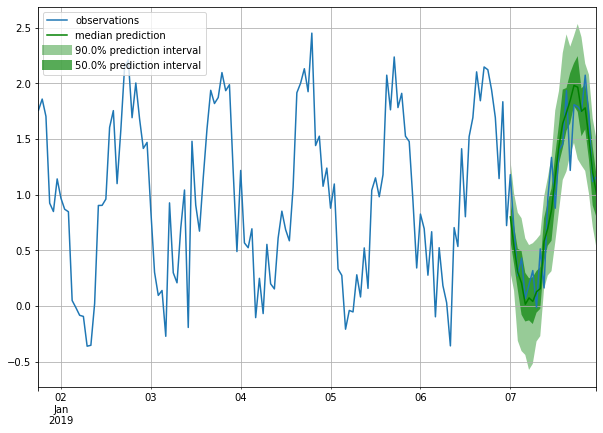

In [95]:
plot_prob_forecasts(tss[0], forecasts[0])

## Add features and scaling
In the previous networks __we used only the target__ and __did not leverage any of the features of the dataset__. Here we expand the probabilistic network by including the `feat_dynamic_real` field of the dataset that could enhance the forecasting power of our model. We achieve this by __concatenating the target and the features to an enhanced vector that forms the new network input__.

All the __features__ that are available in a dataset can be potentially used as __inputs__ to our model. However, for the purposes of this example we will restrict ourselves to using only one feature.

An important issue that a practitioner needs to deal with often is the __different orders of magnitude__ in the values of the time series in a dataset. It is extremely helpful for a model to be trained and forecast values that lie roughly in the same value range. To address this issue, we add a `Scaler` to out model, that computes the scale of each time series.

In [96]:
from gluonts.block.scaler import MeanScaler, NOPScaler

In [97]:
class MyProbNetwork(gluon.HybridBlock):
    def __init__(self,
                 prediction_length,
                 context_length,
                 distr_output,
                 num_cells,
                 num_sample_paths=100,
                 scaling=True,
                 **kwargs
    ) -> None:
        super().__init__(**kwargs)
        self.prediction_length = prediction_length
        self.context_length = context_length
        self.distr_output = distr_output
        self.num_cells = num_cells
        self.num_sample_paths = num_sample_paths
        self.proj_distr_args = distr_output.get_args_proj()
        self.scaling = scaling

        with self.name_scope():
            # Set up a 2 layer neural network that its ouput will be projected to the distribution parameters
            self.nn = mx.gluon.nn.HybridSequential()
            self.nn.add(mx.gluon.nn.Dense(units=self.num_cells, activation='relu'))
            self.nn.add(mx.gluon.nn.Dense(units=self.prediction_length * self.num_cells, activation='relu'))

            if scaling:
                self.scaler = MeanScaler(keepdims=True)
            else:
                self.scaler = NOPScaler(keepdims=True)

    def compute_scale(self, past_target, past_observed_values):
        # scale shape is (batch_size, 1)
        _, scale = self.scaler(
            past_target.slice_axis(
                axis=1, begin=-self.context_length, end=None
            ),
            past_observed_values.slice_axis(
                axis=1, begin=-self.context_length, end=None
            ),
        )

        return scale

In [98]:
class MyProbTrainNetwork(MyProbNetwork):
    def hybrid_forward(self, F, past_target, future_target, past_observed_values, past_feat_dynamic_real):
        # compute scale
        scale = self.compute_scale(past_target, past_observed_values)

        # scale target and time features
        past_target_scale = F.broadcast_div(past_target, scale)
        past_feat_dynamic_real_scale = F.broadcast_div(past_feat_dynamic_real.squeeze(axis=-1), scale)

        # concatenate target and time features to use them as input to the network
        net_input = F.concat(past_target_scale, past_feat_dynamic_real_scale, dim=-1)

        # compute network output
        net_output = self.nn(net_input)

        # (batch, prediction_length * nn_features)  ->  (batch, prediction_length, nn_features)
        net_output = net_output.reshape(0, self.prediction_length, -1)

        # project network output to distribution parameters domain
        distr_args = self.proj_distr_args(net_output)

        # compute distribution
        distr = self.distr_output.distribution(distr_args, scale=scale)

        # negative log-likelihood
        loss = distr.loss(future_target)
        return loss

In [99]:
class MyProbPredNetwork(MyProbTrainNetwork):
    # The prediction network only receives past_target and returns predictions
    def hybrid_forward(self, F, past_target, past_observed_values, past_feat_dynamic_real):
        # repeat fields: from (batch_size, past_target_length) to
        # (batch_size * num_sample_paths, past_target_length)
        repeated_past_target = past_target.repeat(
            repeats=self.num_sample_paths, axis=0
        )
        repeated_past_observed_values = past_observed_values.repeat(
            repeats=self.num_sample_paths, axis=0
        )
        repeated_past_feat_dynamic_real = past_feat_dynamic_real.repeat(
            repeats=self.num_sample_paths, axis=0
        )

        # compute scale
        scale = self.compute_scale(repeated_past_target, repeated_past_observed_values)

        # scale repeated target and time features
        repeated_past_target_scale = F.broadcast_div(repeated_past_target, scale)
        repeated_past_feat_dynamic_real_scale = F.broadcast_div(repeated_past_feat_dynamic_real.squeeze(axis=-1), scale)

        # concatenate target and time features to use them as input to the network
        net_input = F.concat(repeated_past_target_scale, repeated_past_feat_dynamic_real_scale, dim=-1)

        # compute network oputput
        net_output = self.nn(net_input)

        # (batch * num_sample_paths, prediction_length * nn_features)  ->  (batch * num_sample_paths, prediction_length, nn_features)
        net_output = net_output.reshape(0, self.prediction_length, -1)

        # project network output to distribution parameters domain
        distr_args = self.proj_distr_args(net_output)

        # compute distribution
        distr = self.distr_output.distribution(distr_args, scale=scale)

        # get (batch_size * num_sample_paths, prediction_length) samples
        samples = distr.sample()

        # reshape from (batch_size * num_sample_paths, prediction_length) to
        # (batch_size, num_sample_paths, prediction_length)
        return samples.reshape(shape=(-1, self.num_sample_paths, self.prediction_length))

In [100]:
class MyProbEstimator(GluonEstimator):
    @validated()
    def __init__(
            self,
            prediction_length: int,
            context_length: int,
            freq: str,
            distr_output: DistributionOutput,
            num_cells: int,
            num_sample_paths: int = 100,
            scaling: bool = True,
            trainer: Trainer = Trainer()
    ) -> None:
        super().__init__(trainer=trainer)
        self.prediction_length = prediction_length
        self.context_length = context_length
        self.freq = freq
        self.distr_output = distr_output
        self.num_cells = num_cells
        self.num_sample_paths = num_sample_paths
        self.scaling = scaling

    def create_transformation(self):
        # Feature transformation that the model uses for input.
        return Chain(
            [
                AddObservedValuesIndicator(
                    target_field=FieldName.TARGET,
                    output_field=FieldName.OBSERVED_VALUES,
                ),
                InstanceSplitter(
                    target_field=FieldName.TARGET,
                    is_pad_field=FieldName.IS_PAD,
                    start_field=FieldName.START,
                    forecast_start_field=FieldName.FORECAST_START,
                    train_sampler=ExpectedNumInstanceSampler(num_instances=1),
                    past_length=self.context_length,
                    future_length=self.prediction_length,
                    time_series_fields=[
                        FieldName.FEAT_DYNAMIC_REAL,
                        FieldName.OBSERVED_VALUES,
                    ],
                ),

            ]
        )

    def create_training_network(self) -> MyProbTrainNetwork:
        return MyProbTrainNetwork(
            prediction_length=self.prediction_length,
            context_length=self.context_length,
            distr_output=self.distr_output,
            num_cells=self.num_cells,
            num_sample_paths=self.num_sample_paths,
            scaling=self.scaling
        )

    def create_predictor(
            self, transformation: Transformation, trained_network: HybridBlock
    ) -> Predictor:
        prediction_network = MyProbPredNetwork(
            prediction_length=self.prediction_length,
            context_length=self.context_length,
            distr_output=self.distr_output,
            num_cells=self.num_cells,
            num_sample_paths=self.num_sample_paths,
            scaling=self.scaling
        )

        copy_parameters(trained_network, prediction_network)

        return RepresentableBlockPredictor(
            input_transform=transformation,
            prediction_net=prediction_network,
            batch_size=self.trainer.batch_size,
            freq=self.freq,
            prediction_length=self.prediction_length,
            ctx=self.trainer.ctx,
        )

  0%|          | 0/100 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


100%|██████████| 100/100 [00:01<00:00, 96.90it/s, epoch=5/5, avg_epoch_loss=0.444]


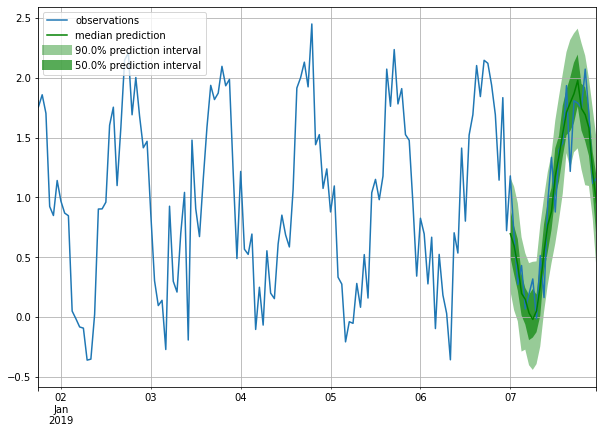

In [101]:
estimator = MyProbEstimator(
    prediction_length=custom_ds_metadata['prediction_length'],
    context_length=2*custom_ds_metadata['prediction_length'],
    freq=custom_ds_metadata['freq'],
    distr_output=GaussianOutput(),
    num_cells=40,
    trainer=Trainer(ctx="cpu",
                    epochs=5,
                    learning_rate=1e-3,
                    hybridize=False,
                    num_batches_per_epoch=100
                   )
)

predictor = estimator.train(train_ds)

forecast_it, ts_it = make_evaluation_predictions(
    dataset=test_ds,  # test dataset
    predictor=predictor,  # predictor
    num_samples=100,  # number of sample paths we want for evaluation
)

forecasts = list(forecast_it)
tss = list(ts_it)

plot_prob_forecasts(tss[0], forecasts[0])